In [24]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
df = pd.read_csv('multivariate_eng_df.csv', parse_dates=['Date'])
df.head()

,Date,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
0,2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
1,2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2,2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
3,2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
4,2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [25]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

#separate univariate dataframe for california
ca_uni_df = ca_df[['Date', 'PEOPLE_POSITIVE_NEW_CASES_COUNT']]
ca_uni_df = ca_uni_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})


In [26]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

In [27]:
#use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()
#fit the model on the training dataset
model_baseline.fit(ca_uni_train)

01:16:29 - cmdstanpy - INFO - Chain [1] start processing
01:16:29 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
print(len(ca_uni_test))

158


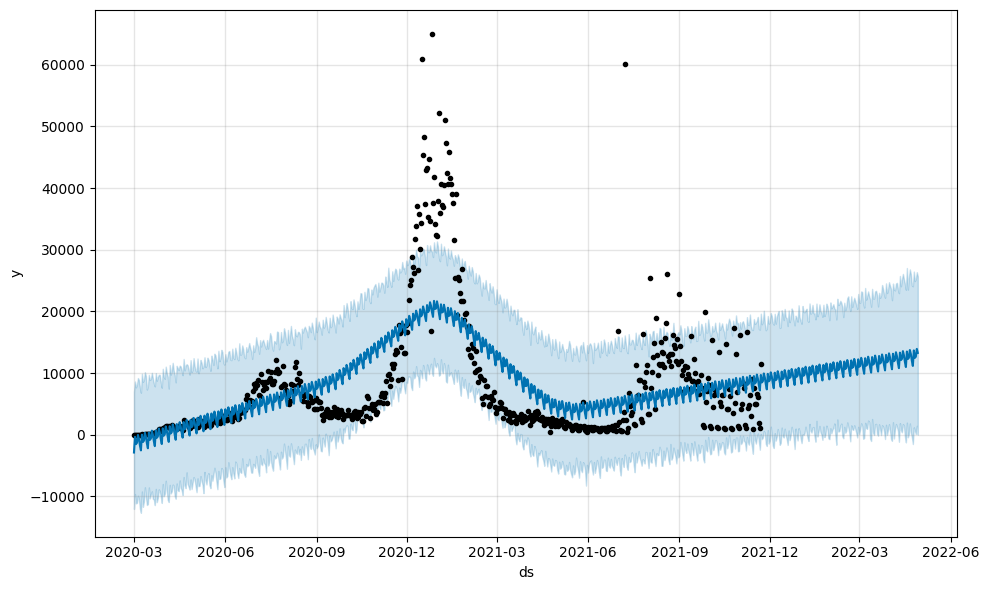

In [29]:
#create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=158)
#make prediction
forecast_baseline = model_baseline.predict(future_baseline)
#visualize the forecast
model_baseline.plot(forecast_baseline); #add semi-colon to remove the duplicated chart

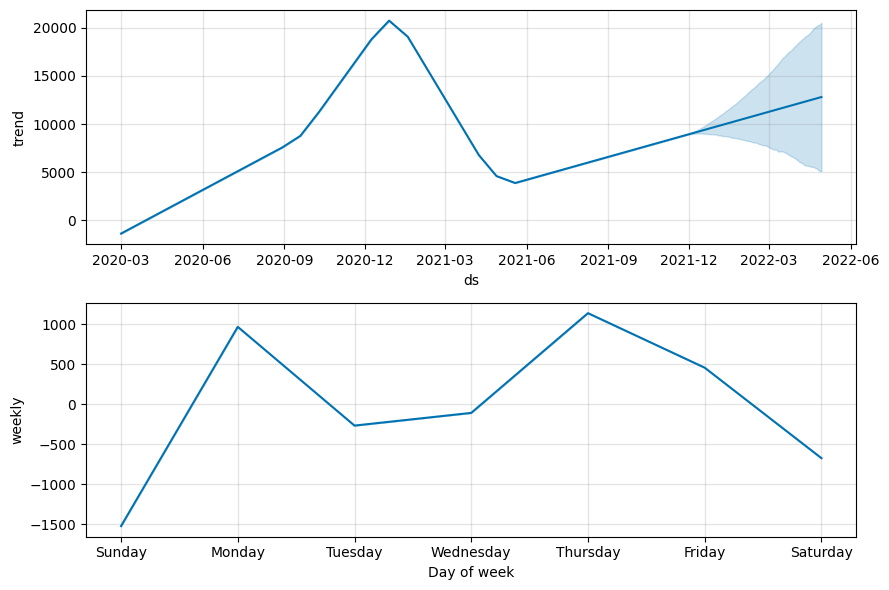

In [30]:
#visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [31]:
#merge actual and predicted values
performance_baseline = pd.merge(ca_uni_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

#check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

#check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 8301.14824773137
The MAPE for the baseline model is 9.825976737939526e+18


In [32]:
#add seasonality into the model
#add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
#fit the model on the training dataset
model_season.fit(ca_uni_train)

01:16:39 - cmdstanpy - INFO - Chain [1] start processing
01:16:39 - cmdstanpy - INFO - Chain [1] done processing


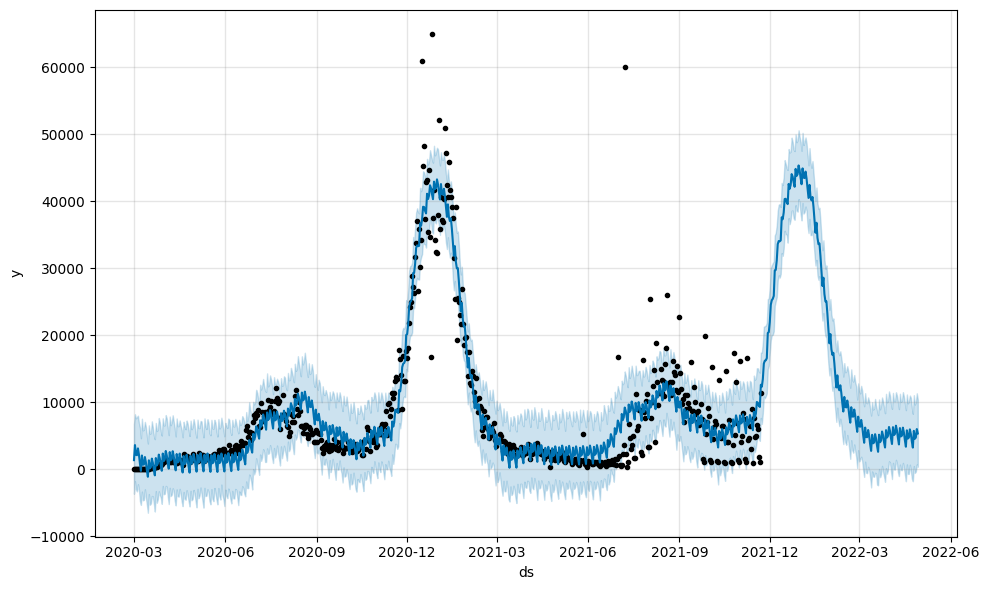

In [33]:
#create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=158)

#make predictions
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

/var/folders/4b/sl3y8zds5g52xl7kl2dsn52w0000gn/T/ipykernel_864/2268752522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_uni_test['ds'] = pd.to_datetime(ca_uni_test['ds'])


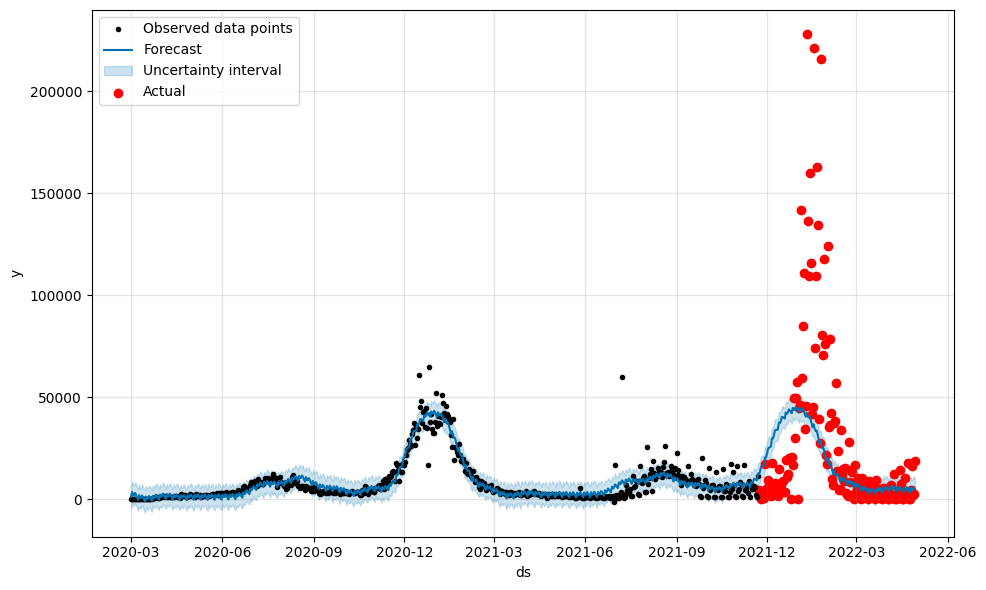

In [12]:
# Plot the forecast
fig = model_season.plot(forecast_season)

# Convert the 'Date' column to datetime if it's not already (adjust 'Date' if your column is named differently)
ca_uni_test['ds'] = pd.to_datetime(ca_uni_test['ds'])

# Plot the actual values on top of the forecast
# Assuming 'Date' is your datetime column and 'y' is the actual values column in ca_uni_test
plt.scatter(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Actual')

# Enhance the plot
plt.legend()
plt.show()

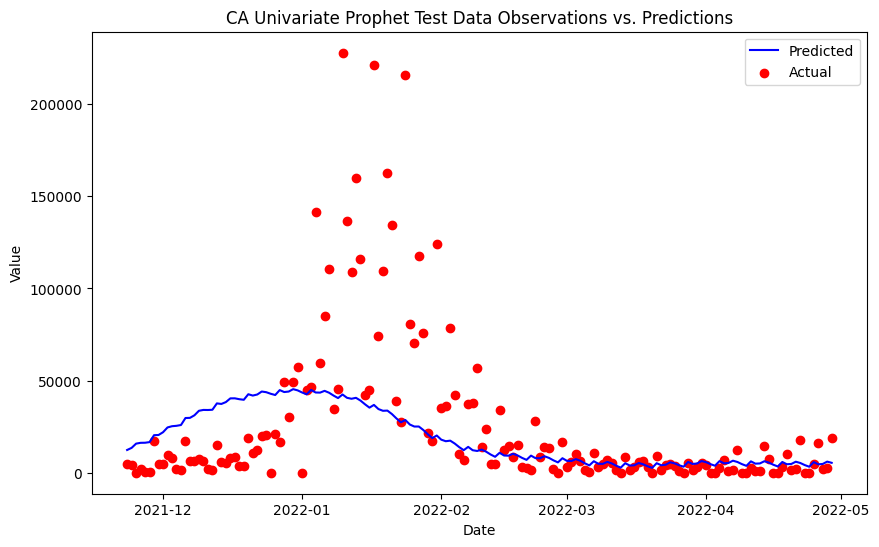

In [39]:
# Filter the forecast data to only include rows where the 'ds' value is within the range of the test dataset
test_period_start = ca_uni_test['ds'].min()
test_period_end = ca_uni_test['ds'].max()

filtered_forecast = forecast_season[(forecast_season['ds'] >= test_period_start)]

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(filtered_forecast['ds'], filtered_forecast['yhat'], label='Predicted', color='blue')

# Overlay the actual test data
plt.scatter(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Actual')

# Enhance the plot with labels and legend
plt.legend()
plt.title('CA Univariate Prophet Test Data Observations vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

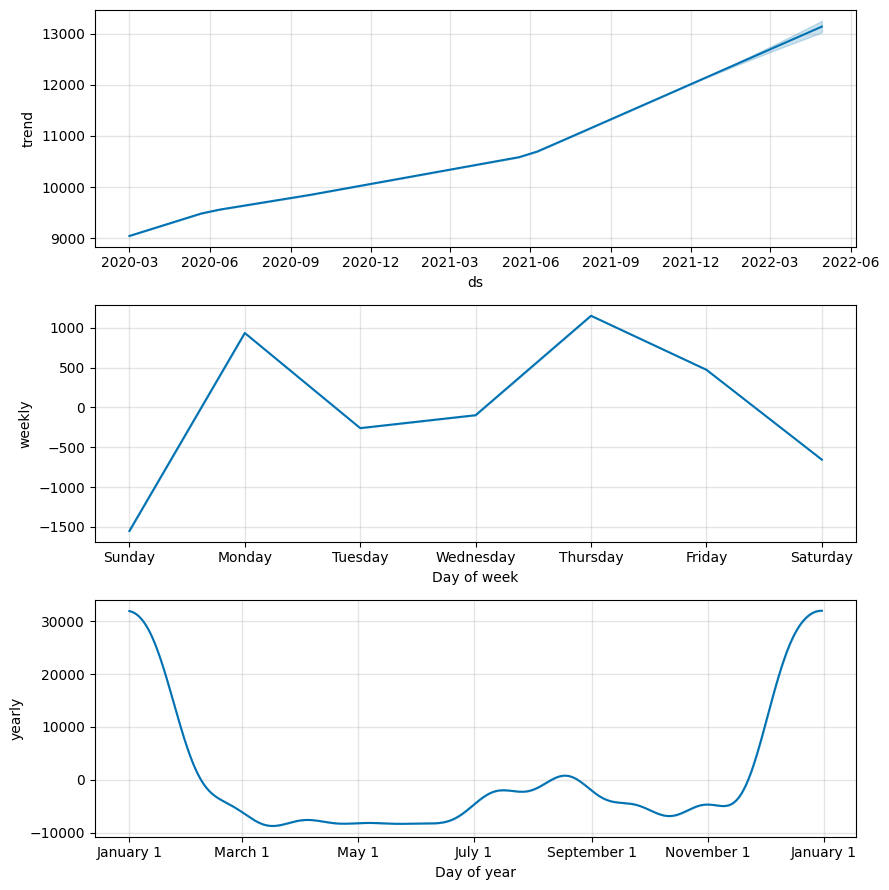

In [40]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [41]:
# Merge actual and predicted values
performance_season = pd.merge(ca_uni_test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 5367.789930042809
The MAPE for the seasonality model is 3.3048247035042294e+18


In [42]:
#naive forecast for mase calculation
naive_forecast = ca_uni_test['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['y'][1:], naive_forecast.dropna())
mase = performance_season_MAE / mae_naive
print('Test MASE: ', mase)

Test MASE:  0.2726015375199285


In [43]:
#calculate performance metrics
mse = mean_squared_error(performance_season['y'], performance_season['yhat'])
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test RMSE:  6566.027643411014
